In [1]:
import torchreid
import torch as t
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_NAME = 'Vrt2_vit50d'
PRETRAIN = True
LOSS_TYPE = 'oim'


# Load data manager
# datamanager = torchreid.data.VideoDataManager(
#     root='/data/reid-data',
#     sources='mars',
#     targets='mars',
#     height=224,  # 256, 128
#     width=224,
#     batch_size_train=BATCH_SIZE,
#     batch_size_test=BATCH_SIZE_TEST,
#     transforms=TRANSFORMS,
#     norm_mean=[0.4058, 0.3852, 0.3730],
#     norm_std=[0.2049, 0.1984, 0.1956],
#     seq_len=SEQ_LEN,
#     train_sampler='RandomIdentitySampler',
#     num_instances=NUM_INSTANCES,
# )


# Build model, optimizer and lr_scheduler
model = torchreid.models.build_model(
    name=MODEL_NAME,
    num_classes=625,
    pretrained=PRETRAIN
)

model = model.cpu()
t.cuda.empty_cache()
torchreid.utils.resume_from_checkpoint('/data/PycharmProjects/deep-person-reid/log/vrt2/vit50_exp3/exp12_seqlen8_feat1feat2twotokens/model/model.pth.tar-192', model)

# torchreid.utils.load_pretrained_weights(model,
#                                         '/data/PycharmProjects/deep-person-reid/log/scan/exp6_res50_bb/model/model.pth.tar-100')



Loading checkpoint from "/data/PycharmProjects/deep-person-reid/log/vrt2/vit50_exp3/exp12_seqlen8_feat1feat2twotokens/model/model.pth.tar-192"
Loaded model weights
Last epoch = 192
Last rank1 = (0.7930508773062708, 0.85, 0.9543478260869566)


192

In [2]:
t.cuda.empty_cache()

In [4]:
sd = torchreid.utils.load_checkpoint('/data/PycharmProjects/deep-person-reid/log/vrt2/vit50_exp3/exp12_seqlen8_feat1feat2twotokens/model/model.pth.tar-192')['state_dict']


len(sd), len(model.state_dict())
for k in model.state_dict():
    if k not in sd:
        print(k)
        
for k in sd:
    if k not in model.state_dict():
        print(k)

In [3]:
list(model.backbone.blocks[0].attn.qkv.parameters())[0]
# print([(name, module) for name, module in model.named_children()])
list(model.backbone.children())[0]


# param_type = []
# param_groups = []

# for name, param in model.named_parameters():
#     if 'backbone.blocks' in name:
#         param_type.append('transformer')
#         param_groups.append({'params': param, 'lr': 1e-3})
#     else:
#         param_type.append('base')
#         param_groups.append({'params': param, 'lr': 1e-3})
    
    
# param_type, param_groups
# list(model.backbone.keys())

from torch.nn.functional import cosine_similarity


# 高度相似
cosine_similarity( (model.backbone.cls_token + model.backbone.pos_embed[:,0:1]), model.backbone.cls_token2, dim=2) 

tensor([[0.9141]], grad_fn=<DivBackward0>)

In [4]:
cls_token0 = model.backbone.cls_token + model.backbone.pos_embed[:,0:1]
cls_token1 = model.backbone.cls_token2

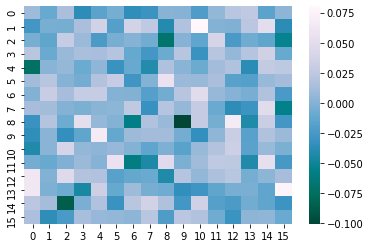

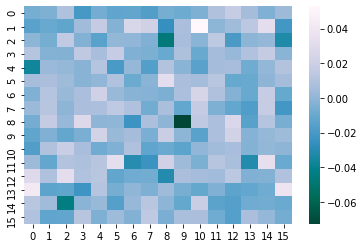

(tensor(0.7153, grad_fn=<CopyBackwards>),
 tensor(0.3915, grad_fn=<CopyBackwards>))

In [5]:
# plt.imshow()
sns.heatmap(cls_token0.view(16,16,3).detach().cpu().numpy()[:,:,1], annot=False, cmap=plt.get_cmap('PuBuGn_r'))
plt.show()

sns.heatmap(cls_token1.view(16,16,3).detach().cpu().numpy()[:,:,1], annot=False, cmap=plt.get_cmap('PuBuGn_r'))
plt.show()

torch.norm(cls_token0), torch.norm(cls_token1), 

Text(0, 0.5, 'max similarity')

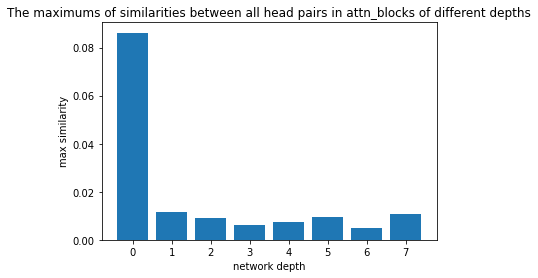

In [6]:
max_head_s = []

num_layer = len(list(model.backbone.blocks))
# q: 0, k: 1, v: 2
q_k_v = 0


for b in range(num_layer):
    
    block_params = list(model.backbone.blocks[b].attn.qkv.parameters())[0].permute(1,0).reshape(768, 3, 8, 768//8)
    w_head = block_params[:, q_k_v, :, :].permute(1, 0, 2).reshape(8, -1)
    
    n = w_head.norm(dim=1).unsqueeze(0)

    S = (w_head @ w_head.t())/(n.t()@n)
    S = S.detach().cpu().numpy()

    mask = np.tril(np.ones((S.shape[0], S.shape[0])), 0).transpose()
    mask = np.logical_not(mask)

    S = S * mask

#     plt.figure(figsize=(12,10))
#     sns.heatmap(S, annot=True)
#     plt.show()

    S.mean(), S.max()
    max_head_s.append(S.max())
    
plt.bar(range(num_layer), max_head_s)
plt.title('The maximums of similarities between all head pairs in attn_blocks of different depths')
plt.xlabel('network depth')
plt.ylabel('max similarity')

Text(0, 0.5, 'max similarity')

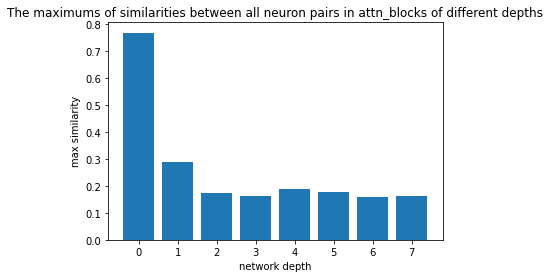

In [7]:


# 8个head中的Wq的列 8*96*768
num_layer = len(list(model.backbone.blocks))
q_k_v = 0

max_neu_s = []

for b in range(num_layer):
    
    block_params = list(model.backbone.blocks[b].attn.qkv.parameters())[0].permute(1,0).reshape(768, 3, 8, 768//8)
    w_neu = block_params[:, q_k_v, :, :].view(768, -1).permute(1, 0)

    n = w_neu.norm(dim=1).unsqueeze(0)

    S = (w_neu @ w_neu.t())/(n.t()@n)
    S = S.detach().cpu().numpy()

    mask = np.tril(np.ones((768,768)), 0).transpose()
    mask = np.logical_not(mask)
    S = S * mask
    
#     plt.figure(figsize=(12,10))
#     sns.heatmap(S*mask, annot=False)
#     plt.show()
    
    max_neu_s.append(S.max())

plt.bar(range(num_layer), max_neu_s)
plt.title('The maximums of similarities between all neuron pairs in attn_blocks of different depths')
plt.xlabel('network depth')
plt.ylabel('max similarity')

0

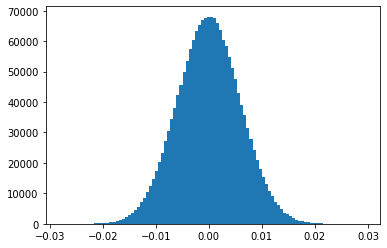

In [8]:
plt.hist(block_params.flatten().detach().cpu().numpy(), 100)
0

In [43]:
import torch
from PIL import Image
from torchvision.transforms import (
    Resize, Compose, ToTensor, Normalize)

transforms = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize([0.4058, 0.3852, 0.3730], [0.2049, 0.1984, 0.1956]),
        ])




# Load an image
img_path = '/data/reid-data/mars/bbox_test/0244/'
img1 = Image.open(img_path + '0244C1T0001F001.jpg')
img2 = Image.open(img_path + '0244C1T0003F006.jpg')
img3 = Image.open(img_path + '0244C3T0011F109.jpg')

img1 = transforms(img1).unsqueeze(0).unsqueeze(0)
img2 = transforms(img2).unsqueeze(0).unsqueeze(0)
img3 = transforms(img3).unsqueeze(0).unsqueeze(0)
img_seq = t.cat([img1, img2, img3], dim=1)
img_seq = t.cat([img_seq, img_seq], dim=0)

# 0244C1T0001F001.jpg
# 0244C1T0003F006.jpg
# 0244C1T0005F029.jpg
# print(img.shape)

# register a hook
raw_attn_map = []
def hook(module, input):
    raw_attn_map.append(input)
# choose the module to visualize
model.backbone.blocks[2].attn.attn_drop.register_forward_pre_hook(hook)

tempo_attn_map = []
def hook_tempo(module, input, input2):
    tempo_attn_map.append(input)
# model.att_model.selfpooling_model.blocks[0].attn.attn_drop.register_forward_pre_hook(hook_tempo)
model.att_model.selfpooling_model.blocks[0].register_forward_hook(hook_tempo)

# Get attn map
model = model.eval()
model(img_seq)

tempo_attn_map = tempo_attn_map[0][0][0].detach().cpu().numpy()
token0_attn_map = raw_attn_map[0][0][0, :, 0, 1:-1] # [8, 196] # 第三维代表我们要看哪个token（关注的地方）
token1_attn_map = raw_attn_map[0][0][0, :, -1, 1:-1] 

attn_map0 = token0_attn_map.reshape(8, 14, 14) # 8个head 
attn_map0 = attn_map0.detach().cpu().numpy()

attn_map1 = token1_attn_map.reshape(8, 14, 14)
attn_map1 = attn_map1.detach().cpu().numpy()

In [44]:
tempo_attn_map = F.softmax(t.from_numpy(tempo_attn_map), dim=1).permute(1,0).numpy()

0.06736193

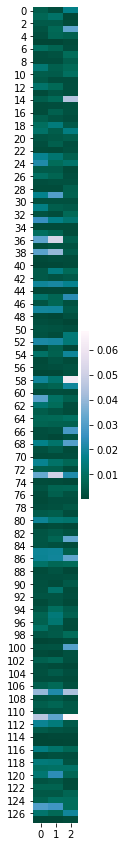

In [45]:
import torch.nn.functional as F

plt.figure(figsize=(1,15))
sns.heatmap(tempo_attn_map, annot=False, cmap=plt.get_cmap('PuBuGn_r'))

tempo_attn_map.max()

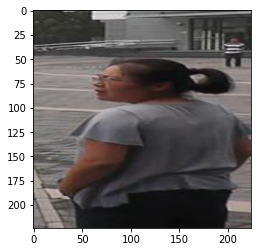

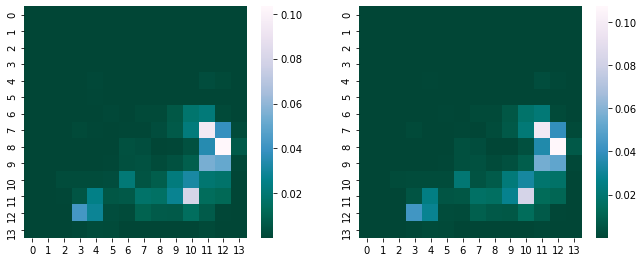

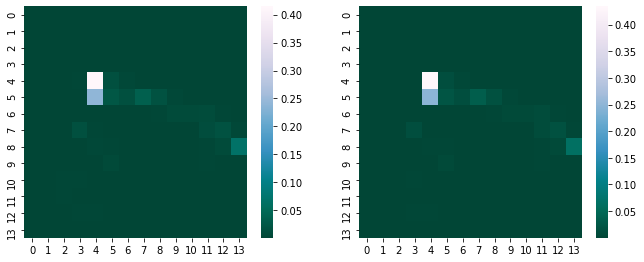

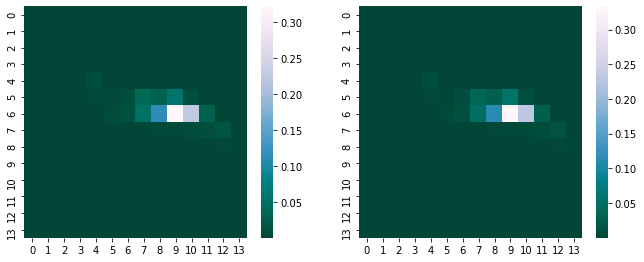

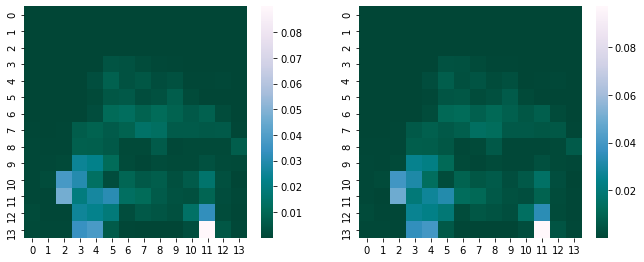

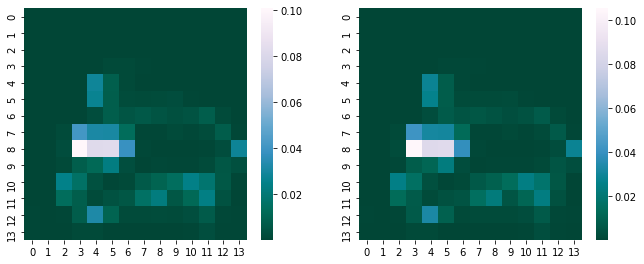

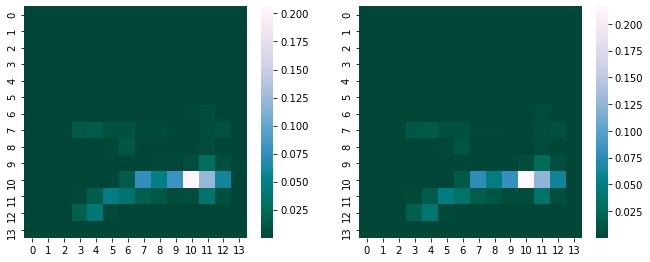

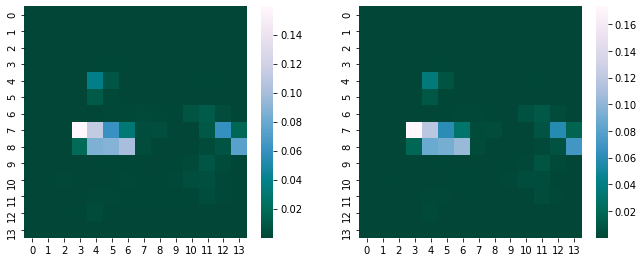

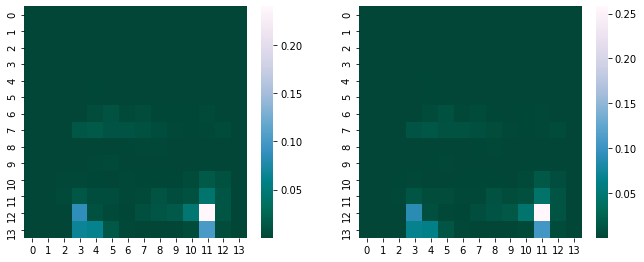

In [46]:
plt.imshow(Image.open(img_path + '0244C1T0001F001.jpg').resize((224, 224)))
plt.show()

for i in range(8):
    plt.figure(figsize=(11,40))
    plt.subplot(8,2,2*i+1)
    sns.heatmap(attn_map0[i], annot=False, cmap=plt.get_cmap('PuBuGn_r'))
    
    plt.subplot(8,2,2*i+2)
    sns.heatmap(attn_map1[i], annot=False, cmap=plt.get_cmap('PuBuGn_r'))
    plt.show()

In [ ]:
# 时序上分析

In [ ]:
# attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())


# plt.figure(figsize=(10,10))
# plt.imshow(attn_map)

In [ ]:


# norm_mean=[0.4058, 0.3852, 0.3730],
#     norm_std=[0.2049, 0.1984, 0.1956],